# Packages

In [1]:
using Pkg; Pkg.activate("."); 
using TSO
using PyPlot
using Glob
using Serialization

  Activating environment at `/cobra/u/peitner/Turbospectrum/opacity_tables/TSO.jl/examples/converting_tables/Project.toml`


# Loading the Tables

In [8]:
paths = glob("OS_table*", "OPAC-for-3D/april23/MaggZ0.0a0.0");

In [9]:
mos = TSO.MARCSOpacity(paths...);

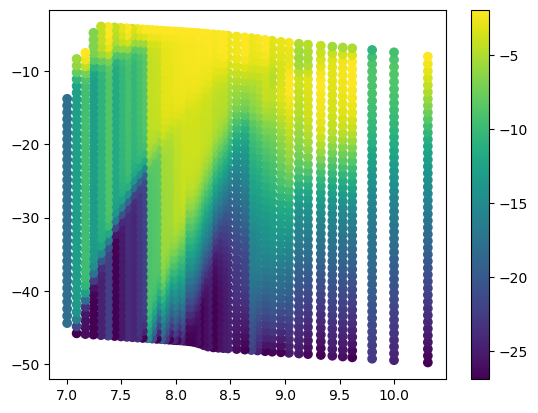

In [110]:
close()

for i in eachindex(mos)
    plt.scatter(log.(mos[i].T), log.(mos[i].ρ), c=log.(mos[i].κ_la[:,80327]))
end

#plt.yscale("log")
#plt.xscale("log")
plt.colorbar()
gcf()

In [11]:
m_int = uniform(mos...);

MARCSOS{Float32, Int32, 1, 2, 2, 1, 3}(Float32[7.0030656, 7.0691833, 7.135301, 7.201419, 7.2675366, 7.3336544, 7.399772, 7.46589, 7.5320077, 7.598125  …  9.713893, 9.78001, 9.846128, 9.912246, 9.978364, 10.044481, 10.1105995, 10.176717, 10.242835, 10.308952], Float32[-38.784348 -38.53385 … -12.517343 -12.356407; -37.49444 -37.24127 … -11.175613 -11.025784; … ; -21.44447 -21.109861 … 22.291286 22.546307; -21.378351 -21.043745 … 22.650124 22.914425], Float32[-24.809658 -24.497812 … 20.127094 20.461693; -24.636826 -24.314926 … 20.180975 20.514893; … ; -20.789412 -20.454803 … 24.067097 24.375288; -20.723293 -20.388687 … 24.171515 24.47868], Float32[-49.75968, -49.425076, -49.09047, -48.75586, -48.421253, -48.086647, -47.75204, -47.417435, -47.082825, -46.74822  …  -6.929989, -6.5953817, -6.2607746, -5.926168, -5.591561, -5.2569537, -4.922347, -4.58774, -4.253133, -3.918526], Float32[30.535429 30.529678 … 27.76187 27.740288; 30.99237 30.987968 … 14.600253 14.018886; … ; 2.9042524f-14 4.0583

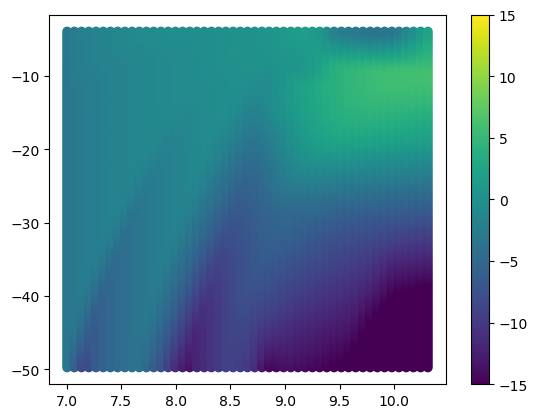

In [98]:
close()

tt, rr = meshgrid(m_int.T, m_int.ρ)

plt.scatter(tt, rr, c=log10.(m_int.κ_la[:,:,81000]), vmin=-15, vmax=15)
plt.colorbar()

gcf()

# Complement with EoS

The MARCS OS tables do not provide internal energy, which is why they need to be complemented with an EoS to get it. Any EoS may be used. The rosseland opacity can either compute by itself (which should be the prefered procedure) or take it from the EoS aswell. The rest can either be taken from this table or from the original EoS.

In [21]:
eos = TSO.reload(TSO.SqEoS, abspath("../../../tests/TSO_sun_Magg_v10.2/eos.hdf5"))
eosMARCS_c = TSO.reload(TSO.SqEoS, "TSO_MARCS_v1.1/combined_eos.hdf5")
opaMARCS_c = TSO.reload(TSO.SqOpacity, "TSO_MARCS_v1.1/combined_opacities.hdf5", mmap=false);

In [63]:
eos_old = reload(SqEoS, "TSO_MARCS_v0.5/combined_eos.hdf5");
opa_old = reload(SqOpacity, "TSO_MARCS_v0.5/combined_opacities.hdf5", mmap=true);

In [22]:
tt, rr = TSO.meshgrid(eosMARCS_c.lnT, eosMARCS_c.lnRho);

In [36]:
c = similar(tt)

for j in axes(c, 2)
    for i in axes(c, 1)
        c[i, j] = argmax(@view(opaMARCS_c.κ[i, j, :]))
    end
end

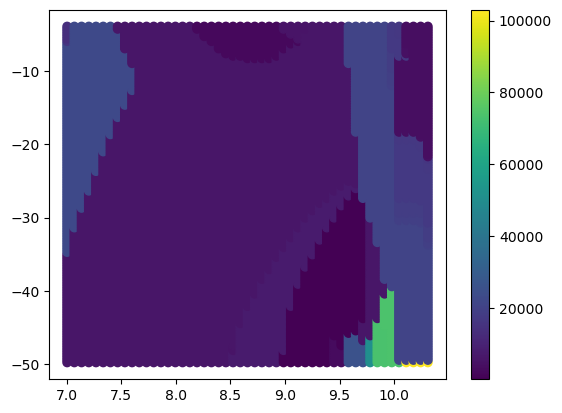

In [38]:
close()
plt.scatter(tt, rr, c=c)
plt.colorbar()
gcf()

In [46]:
solar_model = Average3D(eosMARCS_c, "/u/peitner/Turbospectrum/opacity_tables/tests/stagger_av.dat");

In [66]:
κ     = lookup(eosMARCS_c, opaMARCS_c, :κ, solar_model.lnρ, solar_model.lnT);
κ_old = lookup(eos_old, opa_old,       :κ, solar_model.lnρ, solar_model.lnT);

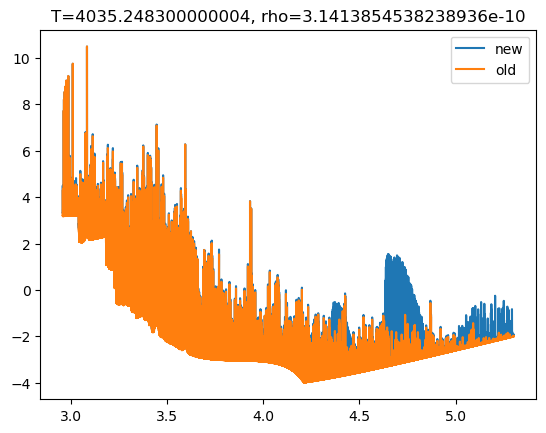

In [87]:
close()

plt.title("T=$(exp(solar_model.lnT[10])), rho=$(exp(solar_model.lnρ[10]))")


plt.plot(log10.(opaMARCS_c.λ), log10.(κ[10, :]), label="new")
plt.plot(log10.(opa_old.λ), log10.(κ_old[10, :]), label="old")

plt.legend()
gcf()

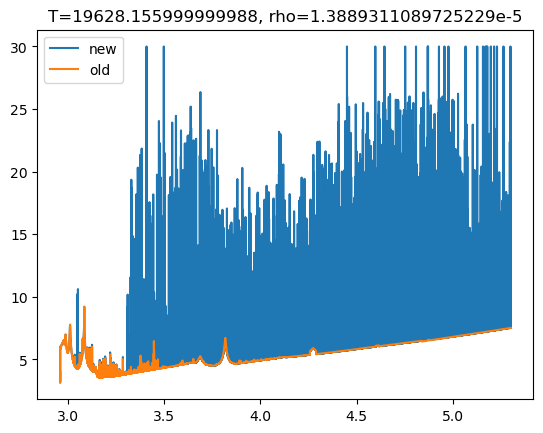

In [117]:
close()

i=200
plt.title("T=$(exp(solar_model.lnT[i])), rho=$(exp(solar_model.lnρ[i]))")


plt.plot(log10.(opaMARCS_c.λ), log10.(κ[i, :]), label="new")
plt.plot(log10.(opa_old.λ), log10.(κ_old[i, :]), label="old")

#plt.xlim(4.75, 4.755)

plt.legend()
gcf()